
# Pré-Processamento: Aprendizagem Automática

## Objetivo
Para um dataset com o histórico de vendas diárias de diversos produtos, será necessário desenvolver uma função que divide os dados de vendas em diferentes dataframes, um para cada produto, criando e treinando dois modelos para um desses dataframes, um para receitas e outro para o nº de unidades vendidas, armazenando o modelo resultado (função Y=mx +b) e prevendo as receitas e o nº de unidades vendidas num ficheiro .csv, para dps este ficheiro ser consumido pelo método de otimização, permitindo que o mesmo usufrua das previsões obtidas. 

Deverão existir dois modelos por produto, um para prever as unidades vendidas no dia seguinte e outro para prever o lucro de vendas do dia seguinte. O período de vendas utilizado será diário ou semanal (a determinar), sendo esta escolha fruto de análise. É importante salientar que o modelo de otimização terá como objetivo otimizar as quantidades a ter em stock durante X semanas, sendo X um valor configurável que representa a periodicidade média de reabastecimento de stock por produto utilizado pela loja, sendo este período representado no mesmo intervalo temporal dos modelos, isto é, em dias ou semanas (a determinar).

In [34]:
%pip install pandas
%pip install xlrd
%pip install openpyxl
%pip install unidecode
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.model_selection import train_test_split
from numpy import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:


# Lemos o dataset
df = pd.read_csv('dataset/revenue.csv')

# Verificamos o dataset carregado
print(df.head(5))


In [ ]:

# Verificamos o período do dataset
def revenue_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'dias')
    print(number_of_years, 'anos')
    
revenue_duration(df)


In [ ]:

# Verificamos que cada produto tem vários registos por dia, dado que para cada produto existem mais registos do que o total de dias acima ilustrado, sendo estes
# referentes às diferentes lojas em que foram vendidos. Porém, para efeitos de análise, iremos agrupar as vendas diárias de cada produto em todas as lojas numa só linha.
print(df['product_id'].value_counts().sort_values(ascending=False).head(15))



In [ ]:


# Verificamos as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



In [ ]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_1'].value_counts().sort_values(ascending=False).head(15))



In [ ]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_2'].value_counts().sort_values(ascending=False).head(15))



In [ ]:


# Removemos as colunas cujas percentagens de inutilização são evidentemente superiores ao aceitável
df = df.drop(columns=["promo_bin_2", "promo_discount_2", "promo_discount_type_2", "promo_bin_1"])

# Removemos as colunas cuja distribuição é quase 100% para um determinado valor, dado que não terão impacto no modelo
df = df.drop(columns=["promo_type_1","promo_type_2"])
print(df.head(5))



In [ ]:


# Verificamos novamente as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



In [ ]:


# Agrupamos as vendas diárias por produto. 
# Para manter o preço diário de cada produto, como este pode variar de loja para loja, inferimos a média do preço diário de cada produto entre todas as lojas.
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['week'] = df.date.dt.isocalendar().week
df2 = df.groupby(["product_id", "year", "month", "week"]).agg({'revenue': ['sum'], 'revenue': ['sum'], 'stock': ['sum'], 'price': ['mean']}).reset_index()
df2.columns = df2.columns.droplevel(1)
df2['date'] = df2.apply(lambda row: datetime.strptime(f'{row.year} {row.week} 1', '%G %V %u'), axis=1)

print(df2.head(15))



In [ ]:

# Verificamos novamente a quantidade de registos por produto, sendo que este valor deverá diminuir drasticamente face à análise igual feita anteriormente
# Assim, a quantidade agora deverá ser igual para todos os produtos, tendo como valor o total de semanas do dataset.
print(df2['product_id'].value_counts().sort_values(ascending=False).head(15))



In [ ]:

# Exportamos o Dataset já agrupado caso seja pretendido analisar os dados ao pormenor. (opcional)
#df2.to_csv('dataset/revenue_grouped.csv')



In [ ]:


# Verificamos novamente as percentagens de dados em falta, já com as vendas agrupadas
percent_missing = df2.isnull().sum() * 100 / len(df2)
percent_missing.sort_values(ascending=False).head()



In [ ]:


# Dividimos o dataframe por produto, dado que irá ser treinado um modelo de previsão para cada um.
dfByProdList = df2.groupby("product_id")

print(len(dfByProdList))

    

In [68]:

# Para efeitos de análise, iremos inicialmente começar por criar um modelo somente para alguns produtos de teste.
product_df_Test1 = dfByProdList.get_group('P0001')
product_df_Test2 = dfByProdList.get_group('P0748')
product_df_Test3 = dfByProdList.get_group('P0125')
print(product_df_Test1.head())



  product_id  year  month  week  sales  revenue   stock    price       date
0      P0001  2017      1     1   24.0   127.17  1318.0  6.25000 2017-01-02
1      P0001  2017      1     2   21.0   112.97  1174.0  6.31713 2017-01-09
2      P0001  2017      1     3   15.0    82.65  1040.0  6.50000 2017-01-16
3      P0001  2017      1     4    8.0    44.08   961.0  6.50000 2017-01-23
4      P0001  2017      1     5    2.0    11.02   266.0  6.50000 2017-01-30


In [ ]:


# Verificamos a distribuição de vendas diárias para os produtos de teste
def sales_per_day(product_sales_data, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day", ylabel = "Count", title = title)
    
def revenue_per_day(product_sales_data, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.revenue, color='mediumblue')
    
    ax.set(xlabel = "Revenue Per day ($)", ylabel = "Count", title = title )


sales_per_day(product_df_Test1, "Distribuição de Vendas Diárias (Produto 1)")
sales_per_day(product_df_Test2, "Distribuição de Vendas Diárias (Produto 2)")
sales_per_day(product_df_Test3, "Distribuição de Vendas Diárias (Produto 3)")
revenue_per_day(product_df_Test1, "Distribuição de Receitas Diárias (Produto 1)")
revenue_per_day(product_df_Test2, "Distribuição de Receitas Diárias (Produto 2)")
revenue_per_day(product_df_Test3, "Distribuição de Receitas Diárias (Produto 3)")




In [ ]:


# Verificamos a média de vendas e receitas diárias
avg_monthly_sales1 = product_df_Test1.sales.mean()
avg_monthly_sales2 = product_df_Test2.sales.mean()
avg_monthly_sales3 = product_df_Test3.sales.mean()
avg_monthly_revenue1 = product_df_Test1.revenue.mean()
avg_monthly_revenue2 = product_df_Test2.revenue.mean()
avg_monthly_revenue3 = product_df_Test3.revenue.mean()
print(f"Média de vendas diárias (Produto 1): {avg_monthly_sales1}")
print(f"Média de vendas diárias (Produto 2): {avg_monthly_sales2}")
print(f"Média de vendas diárias (Produto 3): {avg_monthly_sales3}")
print(f"Média de receitas diárias (Produto 1): ${avg_monthly_revenue1}")
print(f"Média de receitas diárias (Produto 2): ${avg_monthly_revenue2}")
print(f"Média de receitas diárias (Produto 3): ${avg_monthly_revenue3}")



In [ ]:

def time_plot(data, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x = 'date', y = 'sales', data=data, ax=ax, color='blue', label='Total de Vendas')
    sns.lineplot(x = 'date', y = 'revenue', data=data, ax=ax, color='green', label='Total de Receitas') 
    
    ax.set(xlabel = "Date", ylabel = "Sales", title = title)
    
    sns.despine()
    
# Verificamos o histórico de vendas diárias dos produtos ao longo do tempo
time_plot(product_df_Test1, 'Vendas Diárias ao longo do tempo (Produto 1)')
time_plot(product_df_Test2, 'Vendas Diárias ao longo do tempo (Produto 2)')
time_plot(product_df_Test3, 'Vendas Diárias ao longo do tempo (Produto 3)')



In [ ]:
# Deteção de outliers recorrendo a Tukey IQR
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values


In [ ]:


# Verificamos se existem outliers a ter em consideração
tukey_values_sales1 = find_outliers_tukey(product_df_Test1['sales'])
tukey_values_sales2 = find_outliers_tukey(product_df_Test2['sales'])
tukey_values_sales3 = find_outliers_tukey(product_df_Test3['sales'])
tukey_values_revenue1 = find_outliers_tukey(product_df_Test1['revenue'])
tukey_values_revenue2 = find_outliers_tukey(product_df_Test2['revenue'])
tukey_values_revenue3 = find_outliers_tukey(product_df_Test3['revenue'])
print(f"Outliers das Vendas (Produto 1):\n {np.sort(tukey_values_sales1)}\n")
print(f"Outliers das Vendas (Produto 2):\n {np.sort(tukey_values_sales2)}\n")
print(f"Outliers das Vendas (Produto 3):\n {np.sort(tukey_values_sales3)}\n")
print(f"Outliers das Receitas (Produto 1):\n {np.sort(tukey_values_revenue1)}\n")
print(f"Outliers das Receitas (Produto 2):\n {np.sort(tukey_values_revenue2)}\n")
print(f"Outliers das Receitas (Produto 3):\n {np.sort(tukey_values_revenue3)}\n")



In [ ]:


# Verificamos se existem valores em falta para este produto
percent_missing1 = product_df_Test1.isnull().sum()
percent_missing1.sort_values(ascending=False).head()
percent_missing2 = product_df_Test2.isnull().sum()
percent_missing2.sort_values(ascending=False).head()
percent_missing3 = product_df_Test3.isnull().sum()
percent_missing3.sort_values(ascending=False).head()


In [111]:

# Função de preparação pré-previsão, sendo que esta foi separada para poder ser melhorada após análise do desempenho dos modelos obtidos
def prepareBeforePredict(dataframe):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    dataframe1 = dataframe.copy()

    # Criamos uma nova coluna com o nº de vendas e receitas da semana imediatamente anterior
    dataframe1['prev_sales'] = dataframe1['sales'].shift(1)
    dataframe1['prev_revenue'] = dataframe1['revenue'].shift(1)

    # Preenchemos a primeira linha com o valor 0, dado que não existe registo anterior
    dataframe1['prev_sales'] = dataframe1['prev_sales'].fillna(0)
    dataframe1['prev_revenue'] = dataframe1['prev_revenue'].fillna(0)

    return dataframe1


# Verificamos o resultado da preparação
print(prepareBeforePredict(product_df_Test1).head())




  product_id  year  month  week  sales  revenue   stock    price       date  \
0      P0001  2017      1     1     24      127  1318.0  6.25000 2017-01-02   
1      P0001  2017      1     2     21      112  1174.0  6.31713 2017-01-09   
2      P0001  2017      1     3     15       82  1040.0  6.50000 2017-01-16   
3      P0001  2017      1     4      8       44   961.0  6.50000 2017-01-23   
4      P0001  2017      1     5      2       11   266.0  6.50000 2017-01-30   

   prev_sales  prev_revenue  
0           0             0  
1          24           127  
2          21           112  
3          15            82  
4           8            44  


In [185]:


# Função de previsão, devolvendo as métricas de avaliação de desempenho dos modelos obtidos
def find_model_perf(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos o MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculamos o RMSE
    rmse = sqrt(mse)

    # Calculamos o MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculamos o R^2 score
    r2 = r2_score(y_test, y_pred)

    return y_pred, rmse, mae, r2
    


# Função total de previsão, recorrendo às funções de preparação e previsão
def predict(dataframe, model):
    X_sales = dataframe.drop(columns = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue'], axis = 1)
    y_sales = dataframe.sales
    X_revenue = dataframe.drop(columns = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales'], axis = 1)
    y_revenue = dataframe.revenue

    X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, train_size=0.7, random_state=1)
    X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, train_size=0.7, random_state=1)

    y_pred_sales, rmse_sales, mae_sales, r2_sales = find_model_perf(X_train_sales, y_train_sales, X_test_sales, y_test_sales, model)
    y_pred_revenue, rmse_revenue, mae_revenue, r2_revenue = find_model_perf(X_train_revenue, y_train_revenue, X_test_revenue, y_test_revenue, model)

    return y_pred_sales, y_pred_revenue, rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue



In [188]:

model = LogisticRegression(solver='liblinear', max_iter=10000, dual=False)

# Verificamos a variação do desempenho dos modelos de previsão em alguns produtos diferentes
product_df_Test1_prep = prepareBeforePredict(product_df_Test1)
product_df_Test2_prep = prepareBeforePredict(product_df_Test2)
product_df_Test3_prep = prepareBeforePredict(product_df_Test3)
y_pred_sales1, y_pred_revenue1, rmse_sales1, rmse_revenue1, mae_sales1, mae_revenue1, r2_sales1, r2_revenue1 = predict(product_df_Test1_prep, model)
y_pred_sales2, y_pred_revenue2, rmse_sales2, rmse_revenue2, mae_sales2, mae_revenue2, r2_sales2, r2_revenue2 = predict(product_df_Test2_prep, model)
y_pred_sales3, y_pred_revenue3, rmse_sales3, rmse_revenue3, mae_sales3, mae_revenue3, r2_sales3, r2_revenue3 = predict(product_df_Test3_prep, model)

print(f"RMSE das Vendas (Produto 1): {rmse_sales1}")
print(f"RMSE das Vendas (Produto 2): {rmse_sales2}")
print(f"RMSE das Vendas (Produto 3): {rmse_sales3}")
print(f"Média RMSE das Vendas: {(rmse_sales1 + rmse_sales2 + rmse_sales3)/3}")
print(f"\nRMSE das Receitas (Produto 1): {rmse_revenue1}")
print(f"RMSE das Receitas (Produto 2): {rmse_revenue2}")
print(f"RMSE das Receitas (Produto 3): {rmse_revenue3}")
print(f"Média RMSE das Receitas: {(rmse_revenue1 + rmse_revenue2 + rmse_revenue3)/3}")
print(f"\nMAE das Vendas (Produto 1): {mae_sales1}")
print(f"MAE das Vendas (Produto 2): {mae_sales2}")
print(f"MAE das Vendas (Produto 3): {mae_sales3}")
print(f"Média MAE das Vendas: {(mae_sales1 + mae_sales2 + mae_sales3)/3}")
print(f"\nMAE das Receitas (Produto 1): {mae_revenue1}")
print(f"MAE das Receitas (Produto 2): {mae_revenue2}")
print(f"MAE das Receitas (Produto 3): {mae_revenue3}")
print(f"Média MAE das Receitas: {(mae_revenue1 + mae_revenue2 + mae_revenue3)/3}")
print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")



RMSE das Vendas (Produto 1): 13.565976348413493
RMSE das Vendas (Produto 2): 5.063236478416116
RMSE das Vendas (Produto 3): 246.7797239297774
Média RMSE das Vendas: 88.46964558553566

RMSE das Receitas (Produto 1): 91.09394679591583
RMSE das Receitas (Produto 2): 86.24594852144439
RMSE das Receitas (Produto 3): 746.5237772502628
Média RMSE das Receitas: 307.95455752254105

MAE das Vendas (Produto 1): 8.857142857142858
MAE das Vendas (Produto 2): 2.909090909090909
MAE das Vendas (Produto 3): 174.55357142857142
Média MAE das Vendas: 62.10660173160173

MAE das Receitas (Produto 1): 61.892857142857146
MAE das Receitas (Produto 2): 46.18181818181818
MAE das Receitas (Produto 3): 535.8214285714286
Média MAE das Receitas: 214.63203463203465

R2 Score das Vendas (Produto 1): 0.17938276256762808
R2 Score das Vendas (Produto 2): 0.7906317494600432
R2 Score das Vendas (Produto 3): -0.16883351640148048
Média R2 Score das Vendas: 0.26706033187539696

R2 Score das Receitas (Produto 1): 0.17370270917

In [215]:

# Escolhemos o modelo que iremos utilizar, cujas configurações serão analisadas com base nos resultados obtidos para efeitos de otimização
model = LogisticRegression(solver='liblinear', max_iter=1000, dual=False)

# Criamos um dataframe onde serão armazenados os resultados dos modelos obtidos para posterior análise/comparação
modelResults = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])

# Iteramos a lista de dataframes, treinando um modelo para cada produto e armazenando os respetivos resultados
for name, group in dfByProdList:
    group_prep = prepareBeforePredict(group)
    
    if(len(group_prep.sales.unique()) > 3) & (len(group_prep.revenue.unique()) > 3):
        y_pred_sales, y_pred_revenue, rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue = predict(group_prep, model)

        modelResults = pd.concat([modelResults,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, "mae_sales": mae_sales, 
            "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])
    

print(modelResults.head())

C:\Users\silve\AppData\Local\Temp\ipykernel_10220\2121814376.py:10: RuntimeWarning: invalid value encountered in sqrt
  rmse = sqrt(mse)


  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001   13.565976     91.093947  0.179383    0.173703   8.857143   
0      P0002    0.504878     95.594220 -0.139175   -0.138605   0.176471   
0      P0004    3.503797     13.174766 -0.288191   -0.546871   2.404255   
0      P0005    3.696040    127.559720 -0.638680   -0.511147   2.767857   
0      P0006    2.151657     42.322396 -0.409774   -0.405079   1.148148   

   mae_revenue  
0    61.892857  
0    33.352941  
0     9.702128  
0    96.589286  
0    22.592593  


In [216]:


# Verificamos a média do desempenho dos modelos para todos os produtos válidos (com dados suficientes para prever)
print(f"Média MAE de Receitas (Produto 1): {modelResults[modelResults['r2_sales'] > -1].rmse_sales.mean()}")
print(f"Média MAE de Vendas (Produto 1): {modelResults[modelResults['r2_revenue'] > -1].rmse_revenue.mean()}")
print(f"Média MAE de Receitas (Produto 1): {modelResults[modelResults['r2_sales'] > -1].mae_sales.mean()}")
print(f"Média MAE de Vendas (Produto 1): {modelResults[modelResults['r2_revenue'] > -1].mae_revenue.mean()}")
print(f"Média R2 Score  de Vendas (Produto 1): {modelResults[modelResults['r2_sales'] > -1].r2_sales.mean()}")
print(f"Média R2 Score de Receitas (Produto 1): {modelResults[modelResults['r2_revenue'] > -1].r2_revenue.mean()}")




Média MAE de Receitas (Produto 1): 89.25037857767218
Média MAE de Vendas (Produto 1): 379.6481369861401
Média MAE de Receitas (Produto 1): 47.8289502907254
Média MAE de Vendas (Produto 1): 420.3800217324849
Média R2 Score  de Vendas (Produto 1): -0.1455607354931213
Média R2 Score de Receitas (Produto 1): -0.1509255750976627


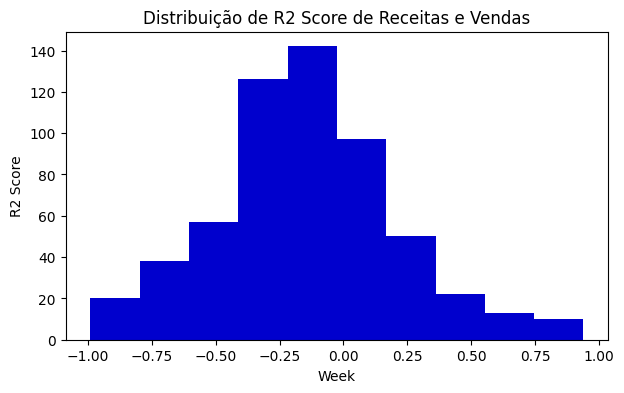

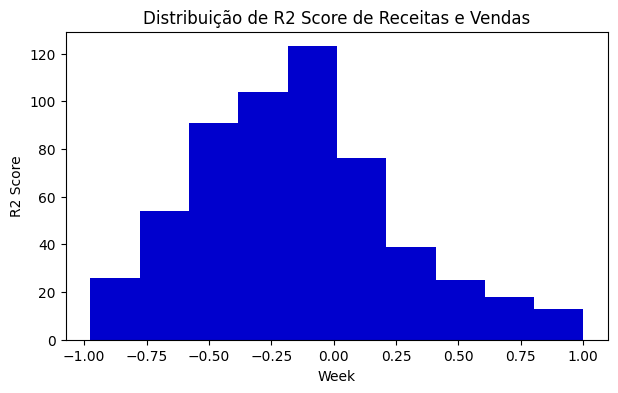

In [217]:

def r2_distribution_sales(modelResults, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(modelResults.r2_sales, color='mediumblue')
    
    ax.set(xlabel = "Week", ylabel = "R2 Score", title = title )

def r2_distribution_revenue(modelResults, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(modelResults.r2_revenue, color='mediumblue')
    
    ax.set(xlabel = "Week", ylabel = "R2 Score", title = title )


# Verificamos a distribuição do R2 Score de todos os modelos obtidos
r2_distribution_sales(modelResults[modelResults['r2_sales'] > -1], "Distribuição de R2 Score de Receitas e Vendas")
r2_distribution_revenue(modelResults[modelResults['r2_revenue'] > -1], "Distribuição de R2 Score de Receitas e Vendas")



In [58]:

from datetime import datetime

XArima = product_df_Test1.date
yArima = product_df_Test1.sales
XArima_train , XArima_test,yArima_train,yArima_test = train_test_split(XArima, yArima, train_size=0.7, random_state=None)



In [59]:
print(XArima[0])

2017-01-02 00:00:00


In [60]:
from statsmodels.tsa.arima.model import ARIMA

def find_model_perf_arima(X_train,y_train,X_test,y_test):

    model = ARIMA(X_train, y_train)
    model = model.fit()
    y_pred = model.predict(X_test)

    # Compute the MSE
    mse = mean_squared_error(y_test, y_pred)

    # Compute the RMSE
    rmse = sqrt(mse)

    # Compute the MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Compute the R^2 score
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [61]:


# Find performance of model using preprocessed data
find_model_perf_arima(XArima_train, yArima_train, XArima_test, yArima_test)



c:\Users\silve\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\silve\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\silve\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('O')